In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

# Загрузка и предобработка данных

In [3]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":]
mcap = pd.read_csv("factors/russia/mcap.csv", parse_dates=True, index_col=0)["2003":]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume  # convert volume from lots to money

prices, mcap, volume = pqr.utils.replace_with_nan(prices, mcap, volume)

# Настраиваем окружение - Юниверс, Бенчмарк и дашборд с инфой по портфелю

In [4]:
universe = volume >= 1_000_000
benchmark = pqr.universe_as_benchmark(
    prices=prices,
    universe=universe,
)

In [5]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

# 1 способ использования: строим факторную модель

In [6]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.filter, universe=universe),
    pqr.utils.partial(pqr.look_back_mean, period=3),
    pqr.utils.partial(pqr.hold, period=3),
)
size = mean_transform(mcap)

portfolios = pqr.backtest_factor_portfolios(
    factor=size,
    prices=prices,
    strategies=pqr.split_quantiles(3),
    allocation=pqr.equal_weights,
    add_wml=True,
)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.29** (2.27),1.54*** (3.00),1.41*** (2.91),-0.17 (-0.38)
"Monthly Volatility, %",8.47,7.62,7.22,6.73
"Maximum Drawdown, %",-77.19,-74.30,-65.45,-77.78
Sharpe Ratio,0.53,0.70,0.68,-0.09
"Mean Excess Return, %",-1.21,1.71,0.21,-18.79
"Alpha, %",-2.21 (-0.64),2.59 (0.82),1.74 (0.60),-4.13 (-0.75)
Beta,1.06,0.95,0.91,0.12


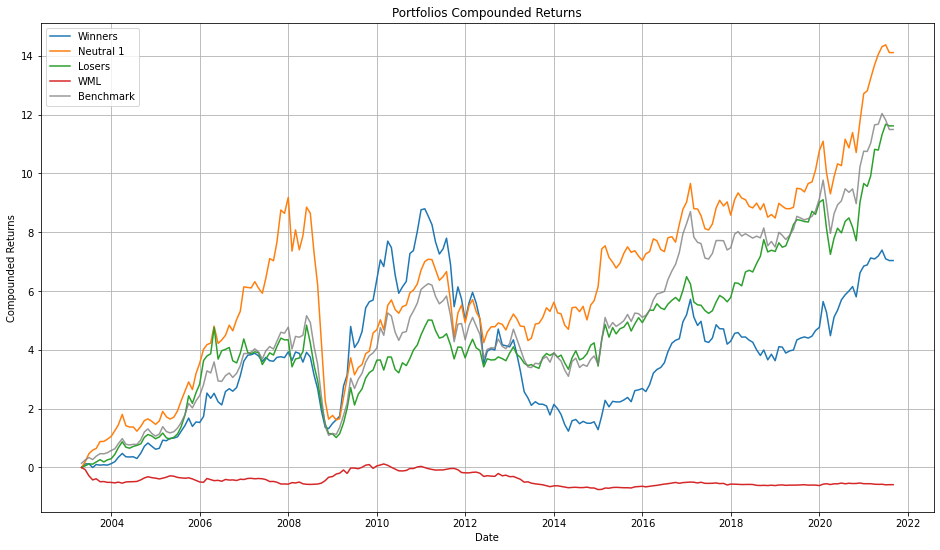

In [7]:
summary(portfolios)

## Поищем модель получше

In [8]:
def mean_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.filter, universe=universe),
        pqr.utils.partial(pqr.look_back_mean, period=looking),
        pqr.utils.partial(pqr.lag, period=lag),
        pqr.utils.partial(pqr.hold, period=holding),
    )


transforms_grid = {
    "(1, 0, 1)": mean_transform_factory(1, 0, 1),
    "(1, 1, 1)": mean_transform_factory(1, 1, 1),
    "(3, 0, 3)": mean_transform_factory(3, 0, 3),
    "(3, 1, 3)": mean_transform_factory(3, 1, 3),
    "(6, 0, 6)": mean_transform_factory(6, 0, 6),
    "(6, 1, 6)": mean_transform_factory(6, 1, 6),
    "(9, 0, 9)": mean_transform_factory(9, 0, 9),
    "(9, 1, 9)": mean_transform_factory(9, 1, 9),
    "(12, 0, 12)": mean_transform_factory(12, 0, 12),
    "(12, 1, 12)": mean_transform_factory(12, 1, 12),
}

results = pqr.grid_search_factor_portfolios(
    prices=prices,
    strategies=pqr.split_quantiles(3),
    factor=mcap,
    transforms=transforms_grid,
    metric=pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
    ),
    add_wml=True,
)

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [9]:
results.round(3)

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.006,-0.008,0.025,0.003
"(1, 1, 1)",-0.014,0.004,0.030,-0.024
"(3, 0, 3)",-0.022,0.026,0.017,-0.041
"(3, 1, 3)",-0.006,0.031,0.022,-0.036
"(6, 0, 6)",0.009,0.031,0.018,-0.027
"(6, 1, 6)",-0.009,0.037,0.009,-0.052
"(9, 0, 9)",0.035,0.014,0.003,0.027
"(9, 1, 9)",0.048,0.011,-0.000,0.038
"(12, 0, 12)",0.031,-0.021,0.026,0.051
"(12, 1, 12)",0.038,-0.019,0.019,0.057


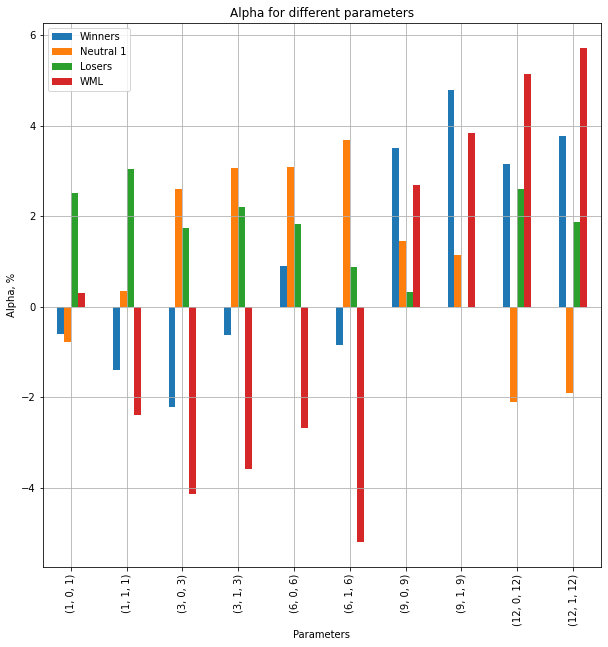

In [10]:
(results * 100).plot.bar(figsize=(10, 10))
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.45*** (2.63),1.03** (1.91),1.28*** (2.48),0.42 (0.92)
"Monthly Volatility, %",8.04,7.85,7.47,6.60
"Maximum Drawdown, %",-71.26,-73.20,-63.01,-73.47
Sharpe Ratio,0.63,0.46,0.59,0.22
"Mean Excess Return, %",2.87,-2.20,0.74,-9.54
"Alpha, %",3.78 (0.96),-1.91 (-0.59),1.88 (0.59),5.72 (1.03)
Beta,0.94,0.98,0.92,-0.05


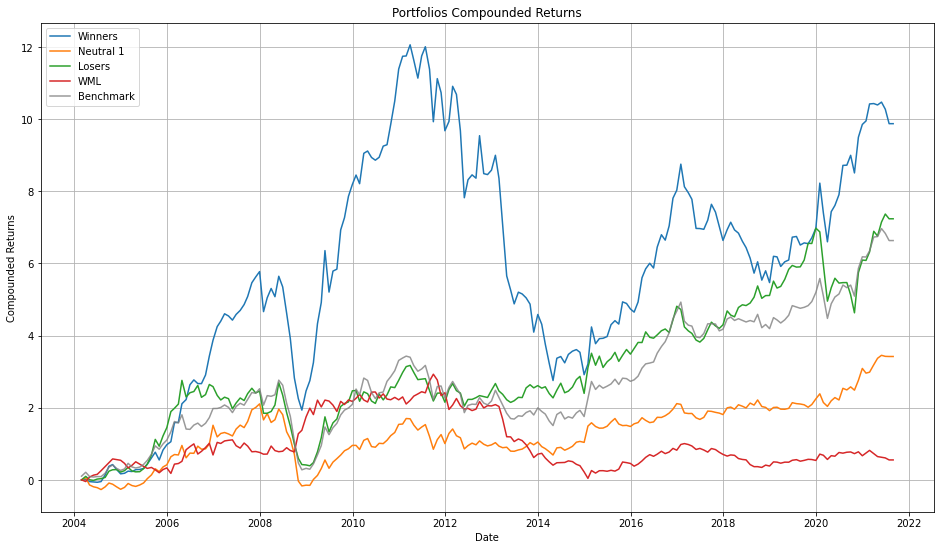

In [11]:
best_portfolios = pqr.backtest_factor_portfolios(
    factor=mean_transform_factory(12, 1, 12)(mcap),
    prices=prices,
    strategies=pqr.split_quantiles(3),
    allocation=pqr.equal_weights,
    add_wml=True,
)

summary(best_portfolios)

### Лучший портфель поподробнее

In [12]:
best_portfolio = best_portfolios[0]

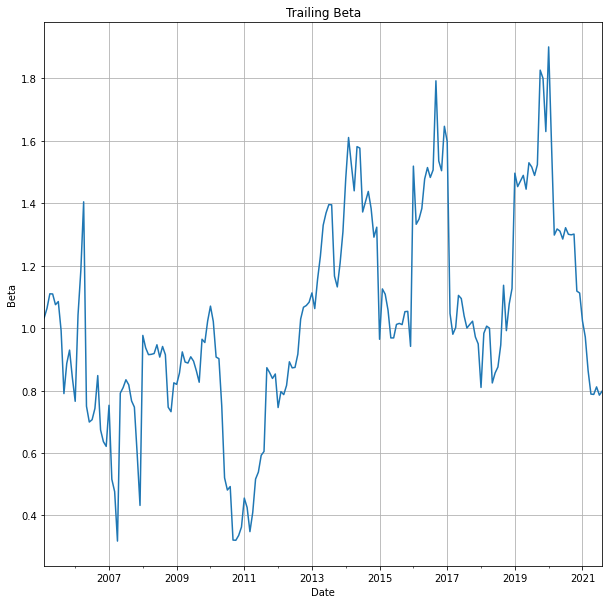

In [13]:
pqr.metrics.trailing_beta(best_portfolio, benchmark).plot(figsize=(10, 10))

plt.title("Trailing Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.grid();

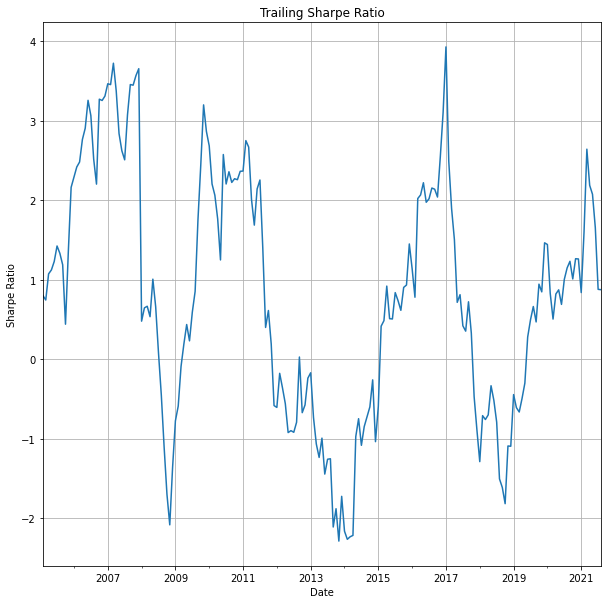

In [14]:
pqr.metrics.trailing_sharpe_ratio(best_portfolio).plot(figsize=(10, 10))

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

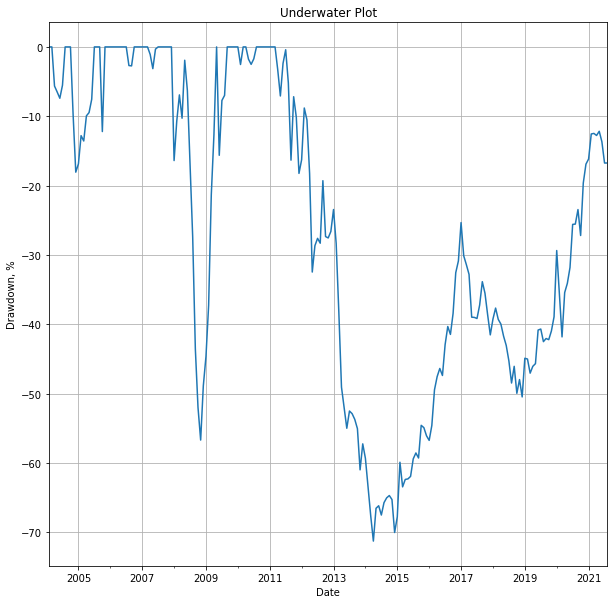

In [15]:
(pqr.metrics.drawdown(best_portfolio) * 100).plot(figsize=(10, 10))

plt.title("Underwater Plot")
plt.xlabel("Date")
plt.ylabel("Drawdown, %")
plt.grid();

# 2 способ использования: строим и настраиваем портфель

,Top 10,Top 10%
"Monthly Mean Return, %",1.74*** (3.30),1.63*** (2.89)
"Monthly Volatility, %",7.85,8.36
"Maximum Drawdown, %",-68.85,-65.82
Sharpe Ratio,0.77,0.67
"Mean Excess Return, %",4.16,2.80
"Alpha, %",5.12 (1.44),3.81 (0.88)
Beta,0.94,0.94


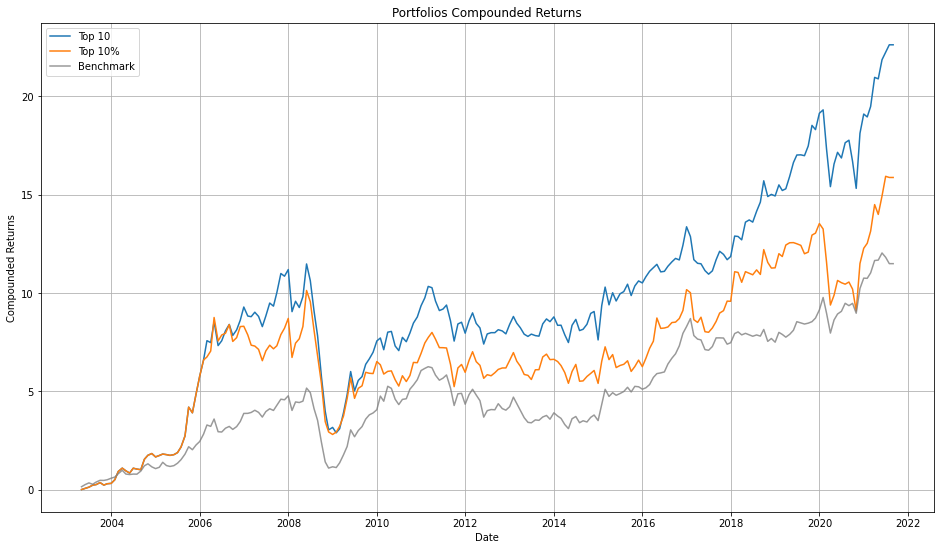

In [16]:
# создадим 2 стратегии отбора акций: топ-10 акций по фактору и топ 10% акций по фактору
# и проинвестируем в оба в нашу изначальную стратегию 3-0-3

top10_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.top(size, 10),
    allocation=pqr.equal_weights,
    name="Top 10"
)

q01_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(size, 0.9, 1),
    allocation=pqr.equal_weights,
    name="Top 10%"
)

summary([top10_portfolio, q01_portfolio])

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

,Top 10,Top 10 Smart Beta
"Monthly Mean Return, %",1.74*** (3.30),1.61*** (3.03)
"Monthly Volatility, %",7.85,7.92
"Maximum Drawdown, %",-68.85,-67.31
Sharpe Ratio,0.77,0.71
"Mean Excess Return, %",4.16,2.63
"Alpha, %",5.12 (1.44),3.82 (1.01)
Beta,0.94,0.93


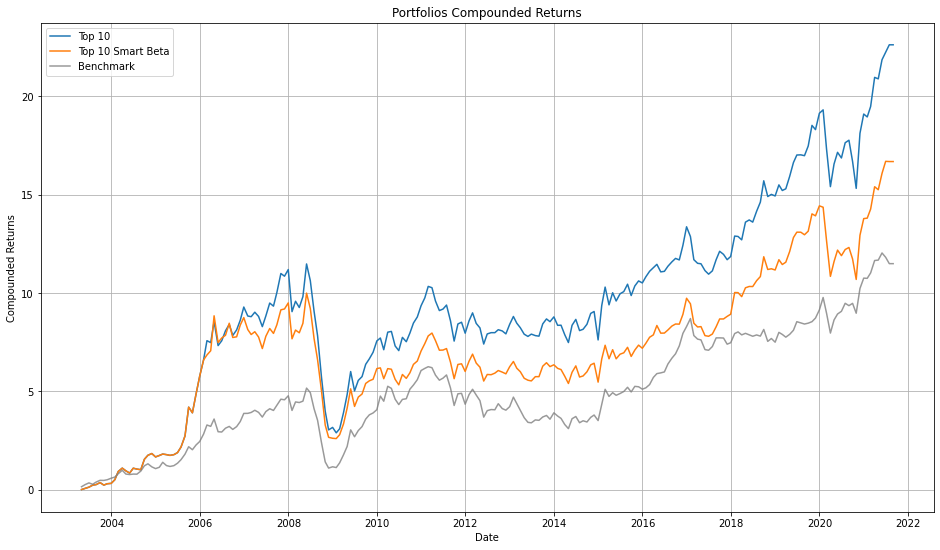

In [17]:
top10_portfolio_smart_beta = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.top(size, 10),
    allocation=pqr.utils.partial(
        pqr.factor_weights,
        factor=size,
    ),
    name="Top 10 Smart Beta"
)

summary([top10_portfolio, top10_portfolio_smart_beta])

Стало лучше, но все равно даже не догоняем бенчмарк. Попробуем применить обратный подход для взвешивания

,Top 10,Top 10 Smart Beta,Top 10 Smart Beta Reversed
"Monthly Mean Return, %",1.74*** (3.30),1.61*** (3.03),1.93*** (3.53)
"Monthly Volatility, %",7.85,7.92,8.14
"Maximum Drawdown, %",-68.85,-67.31,-70.75
Sharpe Ratio,0.77,0.71,0.82
"Mean Excess Return, %",4.16,2.63,6.45
"Alpha, %",5.12 (1.44),3.82 (1.01),7.52* (1.87)
Beta,0.94,0.93,0.94


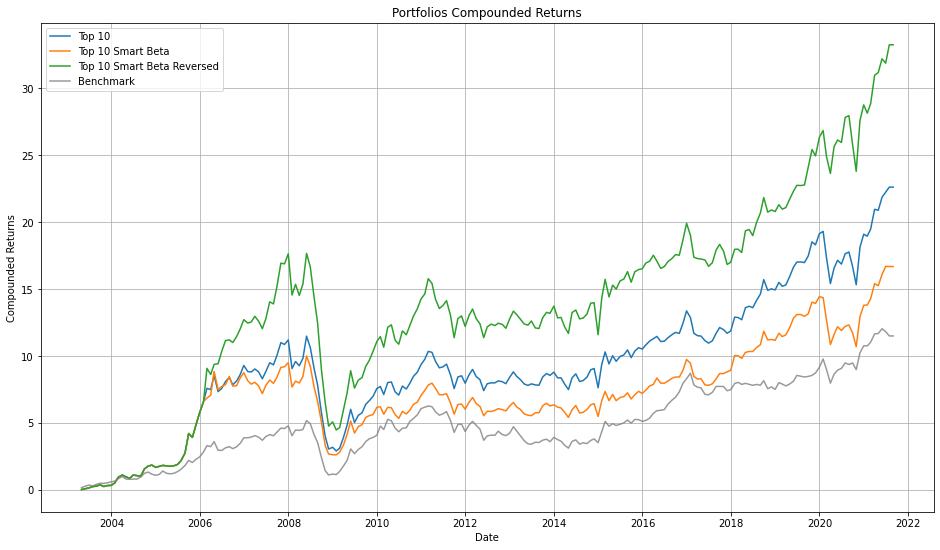

In [18]:
top10_portfolio_smart_beta_reversed = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.top(size, 10),
    allocation=pqr.utils.partial(
        pqr.factor_weights,
        factor=1 / size,
    ),
    name="Top 10 Smart Beta Reversed"
)

summary([
    top10_portfolio,
    top10_portfolio_smart_beta,
    top10_portfolio_smart_beta_reversed
])

# Случайный тест

In [19]:
%%time
%%capture

monkey_est = pqr.tests.monkey_test(
    best_portfolio,
    prices=prices,
    universe=universe,
    allocation=pqr.equal_weights,
    n=1000,
)

CPU times: user 8.28 s, sys: 8.51 ms, total: 8.29 s
Wall time: 8.29 s


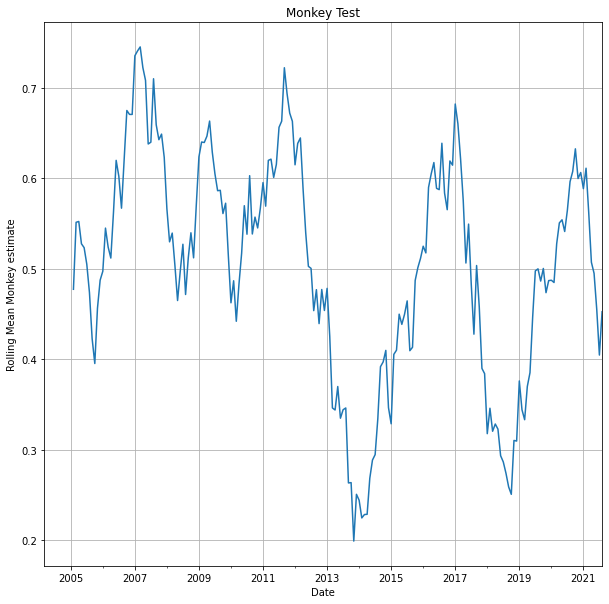

In [20]:
monkey_est.rolling(12).mean().plot(figsize=(10, 10))

plt.title("Monkey Test")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Monkey estimate")
plt.grid();